In [19]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
# 导入lasso模块
from sklearn.linear_model import Lasso
# 导入 train_test_split 模块
from sklearn.model_selection import train_test_split

In [20]:
#rf数据
data_read = pd.read_csv("climate_all_0.csv",header=None)
data_read = data_read.astype(float)
flag = 0
# 去除大部分特征值为 0 的行
data_read = data_read.loc[~(data_read.loc[:,11:34]==0).all(axis=1) &  ~(data_read.loc[:,7:34]==0).all(axis=1),:]

In [6]:
# 处理方法 1 ：将列中 0 多的删除
flag = 1
# 删除第7列（从0开始），因为这一列中大部分是0
data_rover = data_read.drop(columns=7,axis=1)
data_rover = data_rover.drop(columns=28,axis=1)
data_rover = data_rover.drop(columns=29,axis=1)
print(data_rover.shape)
# 重置列索引
data_rover.columns = range(0,33)
# print(data_rover)

(4091, 33)


In [21]:
# 处理方法 2 ：将列中 0 多的列中的0用均值填充
flag = 0
# print(data_read[7]==0)
data_read.loc[data_read[7] == 0,7] = data_read[7].mean()
data_read.loc[data_read[28] == 0,28] = data_read[28].mean()
data_read.loc[data_read[29] == 0,29] = data_read[29].mean()

In [23]:
# 删除行之后的行索引，还是原来删之前的一样，在取数据时，还是按照原来的索引取数据
# 对于不存在的行，会直接略过
if flag == 0:
    features = data_read.loc[0:4199,1:34]
    targets = data_read.loc[0:4199,35]
else:
    features = data_rover.loc[0:4199,1:31]
    targets = data_rover.loc[0:4199,32]
# 切分数据
X_train,X_test,y_train,y_test = train_test_split(features,targets,test_size=0.25,random_state=0)


In [24]:
#第一步定义模型
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, 
                                   scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]  


5.51279065986731

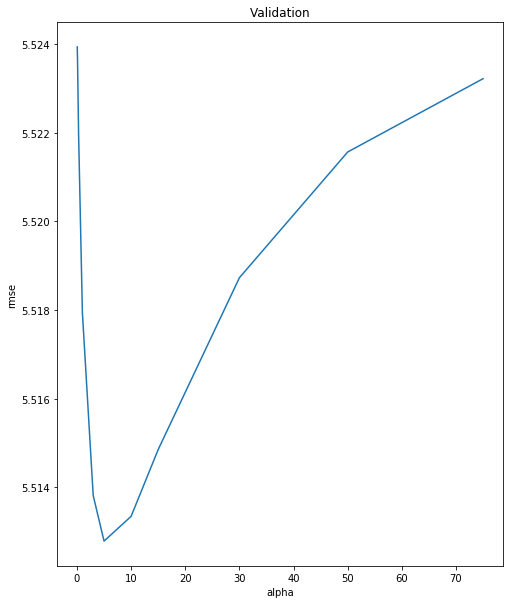

In [25]:
### 第二步 通过RMSE挑选最佳alpha
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()


In [26]:
#第三步 通过lasso模型挑选最佳alpha
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)   
rmse_cv(model_lasso).mean()   



D:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27025.753253012095, tolerance: 12.51838883822331
  tol, rng, random, positive)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29485.496546688315, tolerance: 12.51838883822331
  tol, rng, random, positive)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30866.556029776453, tolerance: 12.46087237000815
  tol, rng, random, positive)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. 

5.681248834769231

In [27]:
##第四步 查看lasso回归变量系数
coef = pd.Series(model_lasso.coef_, index = X_train.columns)   
  
print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")    


Lasso picked 33 variables and eliminated the other 1 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

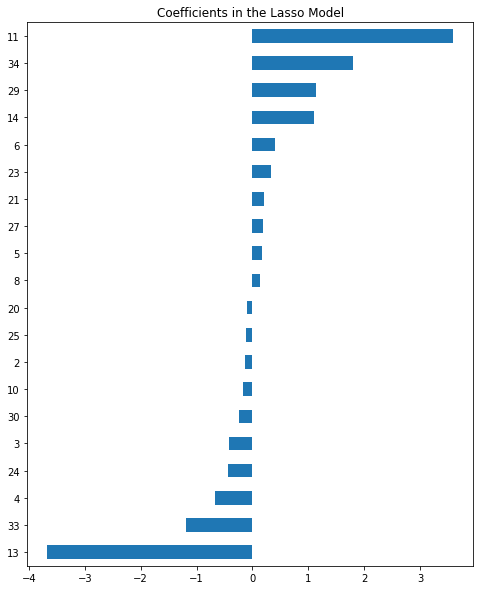

In [28]:
#第五步 查看最重要的变量和最不重要的变量
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


准确率: 0.4596067037591296


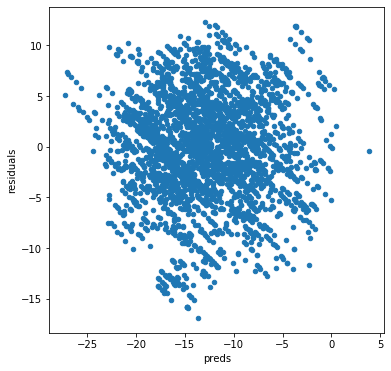

In [29]:
#第六步 查看预测值和真实值之差


#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
score = model_lasso.score(X_test,y_test)
print('准确率:',score)